# Dynamic Time Warping

Based on:
http://nipunbatra.github.io/2014/07/dtw/  

Other sources of information about DTW:  
https://pypi.python.org/pypi/dtw/1.0  
https://github.com/pierre-rouanet/dtw  
http://mlpy.sourceforge.net/docs/3.5/dtw.html  
http://alexminnaar.com/time-series-classification-and-clustering-with-python.html  
http://www.psb.ugent.be/cbd/papers/gentxwarper/DTWalgorithm.htm  
https://www.researchgate.net/profile/Pavel_Senin/publication/228785661_Dynamic_Time_Warping_Algorithm_Review/links/02bfe5100f11a7929f000000.pdf  
http://insy.ewi.tudelft.nl/content/multi-dimensional-dynamic-time-warping-gesture-recognition  
http://epubs.siam.org/doi/pdf/10.1137/1.9781611972757.50  
http://www.mblondel.org/journal/2009/08/31/dynamic-time-warping-theory/  
http://dx.doi.org/10.1371/journal.pone.0136577  
https://docs.google.com/viewer?url=http%3A%2F%2Fwww.psb.ugent.be%2Fcbd%2Fpapers%2Fgentxwarper%2FDTWAlgorithm.ppt  
http://www.cs.rutgers.edu/~mlittman/courses/lightai03/DDTW-2001.pdf  
http://www.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/132_dtw.pdf


In [1]:
import numpy
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import ctypes
import sys

In [2]:
%%file dtw_python.c

#include <stdlib.h>
#include <stdio.h>
#include <math.h>
#include <string.h> // only for the memcpy
#include <errno.h>

/*
    Note: 
    Using ctypes, numpy arrays always look like a vector in C, not a matrix (even if the numpy array IS a matrix)
    The reason is that numpy matrices are always arrays also inside numpy :)    
*/

float path_cost(int len_x, int len_y, float *accumulated_cost, float *distances);
void generates_accumulated_cost(int len_x, int len_y, float *accumulated_cost, float *distances);
void generates_distances(int len_x, int len_y, int dim, float *distances, float *x, float *y);
void returns_path(int *output, int size);

int *path = NULL;
int path_counter = 0;


int returns_path_length(){
    return path_counter;
}

void returns_path(int *output, int size){
    memcpy(output,path,2*sizeof(int)*size);
    free(path);
    path = NULL;
}

float path_cost(int len_x, int len_y, float *accumulated_cost, float *distances)
{
    int i = len_x-1;
    int j = len_y-1;
    int n_malloc_i = 1;
    float min_value = 0;
    float cost = 0;

    path_counter = 0;
    
    if (path == NULL)
    {
        path = malloc(100*2*sizeof(int));
        if (path==NULL)
            return EXIT_FAILURE;
    }
    else
    {
        free(path);
        path = NULL;
        path = malloc(100*2*sizeof(int));
        if (path==NULL)
            return EXIT_FAILURE;        
    }
    
    *path = i;
    *(path+1) = j;
    path_counter++;
    
    while((i>0)||(j>0))
    {        
        if(i==0)
            j = j - 1;
        else if(j==0)
            i = i - 1;
        else
        {
            // Calculates the min value
            if (*(accumulated_cost+((i-1)*len_y)+(j-1))>*(accumulated_cost+((i-1)*len_y)+j))
                min_value = *(accumulated_cost+len_y*(i-1)+j);
            else if (*(accumulated_cost+((i-1)*len_y)+(j-1))>*(accumulated_cost+(i*len_y)+(j-1)))
                min_value = *(accumulated_cost+(i*len_y)+(j-1));
            else
                min_value = *(accumulated_cost+((i-1)*len_y)+(j-1));

            // Calculates the next step based on the min value
            if (*(accumulated_cost+len_y*(i-1)+j) == min_value)
                i = i - 1;
            else if (*(accumulated_cost+len_y*i+(j-1)) == min_value)
                j = j - 1;
            else
            {
                i = i - 1;
                j = j - 1;
            }
        }
                         
        if (((float)path_counter/n_malloc_i)<100)
        {
            *(path+path_counter*2)=i;
            *(path+path_counter*2+1)=j;
            path_counter++;
        }
        else
        {
            n_malloc_i++;
            path = realloc(path,n_malloc_i*100*2*sizeof(int));
            
            if (path==NULL)
                return EXIT_FAILURE;            
            
            *(path+path_counter*2)=i;
            *(path+path_counter*2+1)=j;
            path_counter++;
        }
    }
    for (int i=0; i<path_counter; i++)
    {
        const int x = *(path+i*2);
        const int y = *(path+i*2+1);        
        cost = cost + *(distances+len_y*x+y);
    }
                         
    return cost;
}


void generates_accumulated_cost(int len_x, int len_y, float *accumulated_cost, float *distances)
{
    float min_value = 0;
    
    *(accumulated_cost)= *(distances);
    
    for (int i=1; i<len_y; i++)
        *(accumulated_cost+i) = *(distances+i) + *(accumulated_cost+i-1);
    
    for (int j=1; j<len_x; j++)
        *(accumulated_cost+(j*len_y)) = *(distances+(j*len_y)) + *(accumulated_cost+((j-1)*len_y));    

    for (int i=1; i<len_x; i++)
    {
        for (int j=1; j<len_y; j++)
        {
            // Calculates the min value
            if (*(accumulated_cost+((i-1)*len_y)+(j-1))>*(accumulated_cost+((i-1)*len_y)+j))
                min_value = *(accumulated_cost+len_y*(i-1)+j);
            else if (*(accumulated_cost+((i-1)*len_y)+(j-1))>*(accumulated_cost+(i*len_y)+(j-1)))
                min_value = *(accumulated_cost+(i*len_y)+(j-1));
            else
                min_value = *(accumulated_cost+((i-1)*len_y)+(j-1));

            *(accumulated_cost+(i*len_y)+j)= min_value + *(distances+(i*len_y)+j);
        }
        
    }
}

void generates_distances(int len_x, int len_y, int dim, float *distances, float *x, float *y)
{
    for (int i=0; i<len_x; i++)
    {
        for (int j=0; j<len_y; j++)
        {
            *(distances+(i*len_y)+j) = 0; //initialises
            
            if (dim>1)
                for (int d=0; d<dim; d++)
                {
                    *(distances+(i*len_y)+j) += pow(*(x+(i*dim)+d)-*(y+(j*dim)+d),2);
                }
            else
                *(distances+(i*len_y)+j) += pow(*(x+i)-*(y+j),2);
            
            *(distances+(i*len_y)+j) = sqrt(*(distances+(i*len_y)+j));
            
        }
    }
}


Overwriting dtw_python.c


In [3]:
# In Linux it's necessary to add these: -lrt -lm
!gcc -shared -Wl,-install_name,dtw_python.so -o dtw_python.so -fPIC dtw_python.c -O3 -std=gnu99 -Wall -ffast-math -mtune=native 

In [4]:
%%file dtw_C.py

import numpy
import ctypes

DTW=ctypes.CDLL("./dtw_python.so")

# void generates_distances(int len_x, int len_y, int dim, float *distances, float *x, float *y)
generates_distances = DTW.generates_distances
generates_distances.restype = None
generates_distances.argtypes = [
    ctypes.c_int32,
    ctypes.c_int32,
    ctypes.c_int32,
    numpy.ctypeslib.ndpointer(dtype=numpy.float32, flags='ALIGNED,C_CONTIGUOUS'),
    numpy.ctypeslib.ndpointer(dtype=numpy.float32, flags='ALIGNED,C_CONTIGUOUS'),
    numpy.ctypeslib.ndpointer(dtype=numpy.float32, flags='ALIGNED,C_CONTIGUOUS')]

def distances_matrix(x,y):

    assert len(x.shape)==len(y.shape), "Inputs must have the same number of columns"
    
    if len(x.shape)==1:
        dim = ctypes.c_int32(1)
    else:
        dim = ctypes.c_int32(x.shape[1])
    
    len_x = ctypes.c_int32(x.shape[0])
    len_y = ctypes.c_int32(y.shape[0]) 
    
    distances = numpy.empty((x.shape[0],y.shape[0]),dtype=numpy.float32)
    
    
    generates_distances(len_x, len_y, dim, distances, x.astype(dtype=numpy.float32), y.astype(dtype=numpy.float32))
    
    return distances#.reshape((x.shape[0],y.shape[0]))

# void generates_accumulated_cost(int len_x, int len_y, float *accumulated_cost, float *distances)
generates_accumulated_cost = DTW.generates_accumulated_cost
generates_accumulated_cost.restype = None
generates_accumulated_cost.argtypes = [
    ctypes.c_int32,
    ctypes.c_int32,
    numpy.ctypeslib.ndpointer(dtype=numpy.float32, flags='ALIGNED,C_CONTIGUOUS'),
    numpy.ctypeslib.ndpointer(dtype=numpy.float32, flags='ALIGNED,C_CONTIGUOUS')]

def accumulated_cost_matrix(x,y,distances):
    len_x = ctypes.c_int32(x.shape[0])
    len_y = ctypes.c_int32(y.shape[0]) 
    accumulated_cost = numpy.empty((x.shape[0],y.shape[0]),dtype=numpy.float32)
    
    generates_accumulated_cost(len_x, len_y, accumulated_cost, distances)
    
    return accumulated_cost

# float path_cost(int len_x, int len_y, float *accumulated_cost, float *distances)
path_cost = DTW.path_cost
path_cost.restype = ctypes.c_float
path_cost.argtypes = [
    ctypes.c_int32,
    ctypes.c_int32,
    numpy.ctypeslib.ndpointer(dtype=numpy.float32, flags='ALIGNED,C_CONTIGUOUS'),
    numpy.ctypeslib.ndpointer(dtype=numpy.float32, flags='ALIGNED,C_CONTIGUOUS')]

# int returns_path_length()
returns_path_length = DTW.returns_path_length
returns_path_length.restype = ctypes.c_int32
returns_path_length.argtypes = []

# void returns_path(int *output, int size)
returns_path = DTW.returns_path
returns_path.restype = None
returns_path.argtypes = [
    numpy.ctypeslib.ndpointer(dtype=numpy.int32, flags='ALIGNED,C_CONTIGUOUS'),
    ctypes.c_int32]


def path_cost_calculation(x,y,distances,accumulated_cost):
    len_x = ctypes.c_int32(x.shape[0])
    len_y = ctypes.c_int32(y.shape[0]) 
    
    cost = path_cost(len_x, len_y, accumulated_cost, distances)

    path_length = returns_path_length()
    
    path = numpy.empty((path_length,2),dtype=numpy.int32)
    
    returns_path(path, path_length)
    
    return path,cost

Overwriting dtw_C.py


In [2]:
import dtw_C
reload(sys.modules['dtw_C'])

<module 'dtw_C' from 'dtw_C.pyc'>

In [3]:
def distance_cost_plot(distances,xlabel="x",ylabel="y",all_ticks=False,figure=True):
    distances=distances.T
    if figure:
        plt.figure(figsize =(10,10))
    plt.imshow(distances, interpolation='nearest', cmap='Reds') 
    plt.gca().invert_yaxis()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if all_ticks:
        plt.xticks(range(distances.shape[1]),range(distances.shape[1]))
        plt.yticks(range(distances.shape[0]),range(distances.shape[0]))
    plt.grid()
    plt.colorbar();

In [4]:
def path_cost_p(x, y, accumulated_cost, distances):
    
    path = [[len(x)-1, len(y)-1]]
    
    cost = 0
    
    i = len(x)-1
    j = len(y)-1
    
    while i>0 or j>0:
        if i==0:
            j = j - 1
        elif j==0:
            i = i - 1
        else:
            if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                i = i - 1
            elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                j = j - 1
            else:
                i = i - 1
                j = j - 1
        path.append([i, j])
    for [x, y] in path:
        cost = cost +distances[x, y]
    return path, cost

In [5]:
def generates_accumulated_cost_p(x,y,distances):
    accumulated_cost = numpy.zeros((len(x), len(y)))
    
    accumulated_cost[0,0] = distances[0,0]
    
    for i in range(1, len(x)):
        accumulated_cost[i,0] = distances[i, 0] + accumulated_cost[i-1, 0]

    for j in range(1, len(y)):
        accumulated_cost[0,j] = distances[0,j] + accumulated_cost[0, j-1]
        
    for i in range(1, len(x)):
        for j in range(1, len(y)):
            accumulated_cost[i, j] = min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]) + distances[i, j]
            
    return accumulated_cost

In [6]:
def generates_distances2D(x,y):
    '''
    Generates the distance matrix used with Dynamic Time Warping
    '''
    # Creates the helper matrix
    helper_matrix=numpy.ones((y.shape[0],x.shape[0]))

    # Generates (y.shape[0]) copies of each value in original_drawing
    x_all=(x[:,0]*helper_matrix)
    y_all=(x[:,1]*helper_matrix)

    # returns all the distances between original points and generated ones
    return (numpy.sqrt((x_all.T-y[:,0])**2+(y_all.T-y[:,1])**2))

In [7]:
def generates_distances3D(x,y):
    '''
    Generates the distance matrix used with Dynamic Time Warping
    '''
    # Creates the helper matrix
    helper_matrix=numpy.ones((y.shape[0],x.shape[0]))

    # Generates (y.shape[0]) copies of each value in original_drawing
    x_all=(x[:,0]*helper_matrix)
    y_all=(x[:,1]*helper_matrix)
    z_all=(x[:,2]*helper_matrix)

    # returns all the distances between original points and generated ones
    return (numpy.sqrt((x_all.T-y[:,0])**2+(y_all.T-y[:,1])**2+(z_all.T-y[:,2])**2))

In [8]:
def generates_distances_N(x,y):
    '''
    Generates the distance matrix used with Dynamic Time Warping 
    => for systems with N dimensions
    '''
    assert len(x.shape)==len(y.shape), "Inputs must have the same number of columns"
    
    if len(x.shape)==1:
        x=x.reshape((x.shape[0],1))
        y=y.reshape((y.shape[0],1))
    
    assert x.shape[1]==y.shape[1], "Inputs must have the same number of columns" # verifies if the second dimension matches
    # Creates the helper matrix
    helper_matrix=numpy.ones((y.shape[0],x.shape[0]))

    # returns all the distances between original points and generated ones
    return (numpy.sqrt(numpy.array([((x[:,i]*helper_matrix).T-y[:,i])**2 for i in range(x.shape[1])]).sum(axis=0)))

# Examples

# Nice Square vs Noisy One

In [9]:
import save_load_file as slf
sim_set = "square" # basically is the name of the folder where the data is read/saved
base_dir = "BaxterArm_VREP_simulation_data"

square=slf.load_from_file(base_dir+"/"+sim_set+"/"+"square.pickle")


# extra_name_r='_ROB_0' # almost no noise
# extra_name_r='_ROB_10' # 10% increase in noise
# extra_name_r='_ROB_20' # 20% increase in noise
# extra_name_r='_ROB_30' # 30% increase in noise
# extra_name_r='_ROB_40' # 40% increase in noise
extra_name_r='_ROB_50' # 50% increase in noise

# extra_name = "_Maass_Parallel"
extra_name = ""

extra_name = extra_name+extra_name_r

simulation_type = "parallel"

lsm_i = "ALL"

total_trials = 100
xyz_pos = []
for trial_number in range(total_trials):
    filename = "./"+base_dir+"/"+sim_set+"/baxter_xyz_joint_angles_mean_"+simulation_type+"_"+\
               str(lsm_i)+"_"+str(trial_number)+extra_name+"_VREP.npy"
    xyz_pos.append(numpy.load(filename))

xyz_pos = numpy.array(xyz_pos)

# Translates to match the original initial value (as the simulations always start at that value)
xyz_pos[:,:,0]+=-xyz_pos[0,0,0]+square[0,0]
xyz_pos[:,:,1]+=-xyz_pos[0,0,1]+square[0,1]
xyz_pos[:,:,2]+=-xyz_pos[0,0,2]

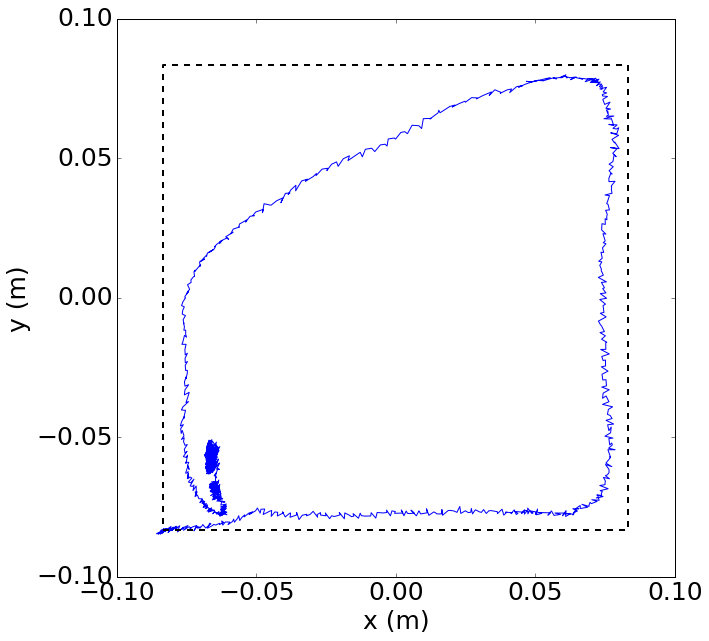

In [10]:
# I will use i=2, i=60 and i=99
i=60
description = "noisy square"
noisy_sq = numpy.copy(xyz_pos[i,:,0:2])
# and the original square scaled down:
# noisy_sq = numpy.copy(square*0.9)
# description = "rescaled square"

font = {'weight' : 'normal',
        'size'   : 25}

matplotlib.rc('font', **font)

count_good = []
plt.figure(figsize =(10,10))
plt.plot(noisy_sq[:,0],noisy_sq[:,1])
plt.plot(square[:,0],square[:,1],'k--',linewidth=2)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
# plt.title("Cartesian Movement Generated by Baxter (all trials) - "+simulation_type)
# plt.savefig(os.getcwd()+"/"+"final_xy_"+shape_name[shape_i][:-1]+"_"+simulation_type+".pdf", bbox_inches='tight',pad_inches=.1)
plt.show()

In [11]:
dist=dtw_C.distances_matrix(square,noisy_sq)
# distance_cost_plot(dist,xlabel="square",ylabel=description)

In [12]:
accumulated_cost=dtw_C.accumulated_cost_matrix(square,noisy_sq,dist)
path,cost = dtw_C.path_cost_calculation(square,noisy_sq,dist,accumulated_cost)
# distance_cost_plot(accumulated_cost,xlabel="square",ylabel="noisy square")
# plt.plot(path[:,0],path[:,1],'.-')
# plt.xlim(0,path[0,0])
# plt.ylim(0,path[0,1])
# plt.show()

print cost

42.122505188


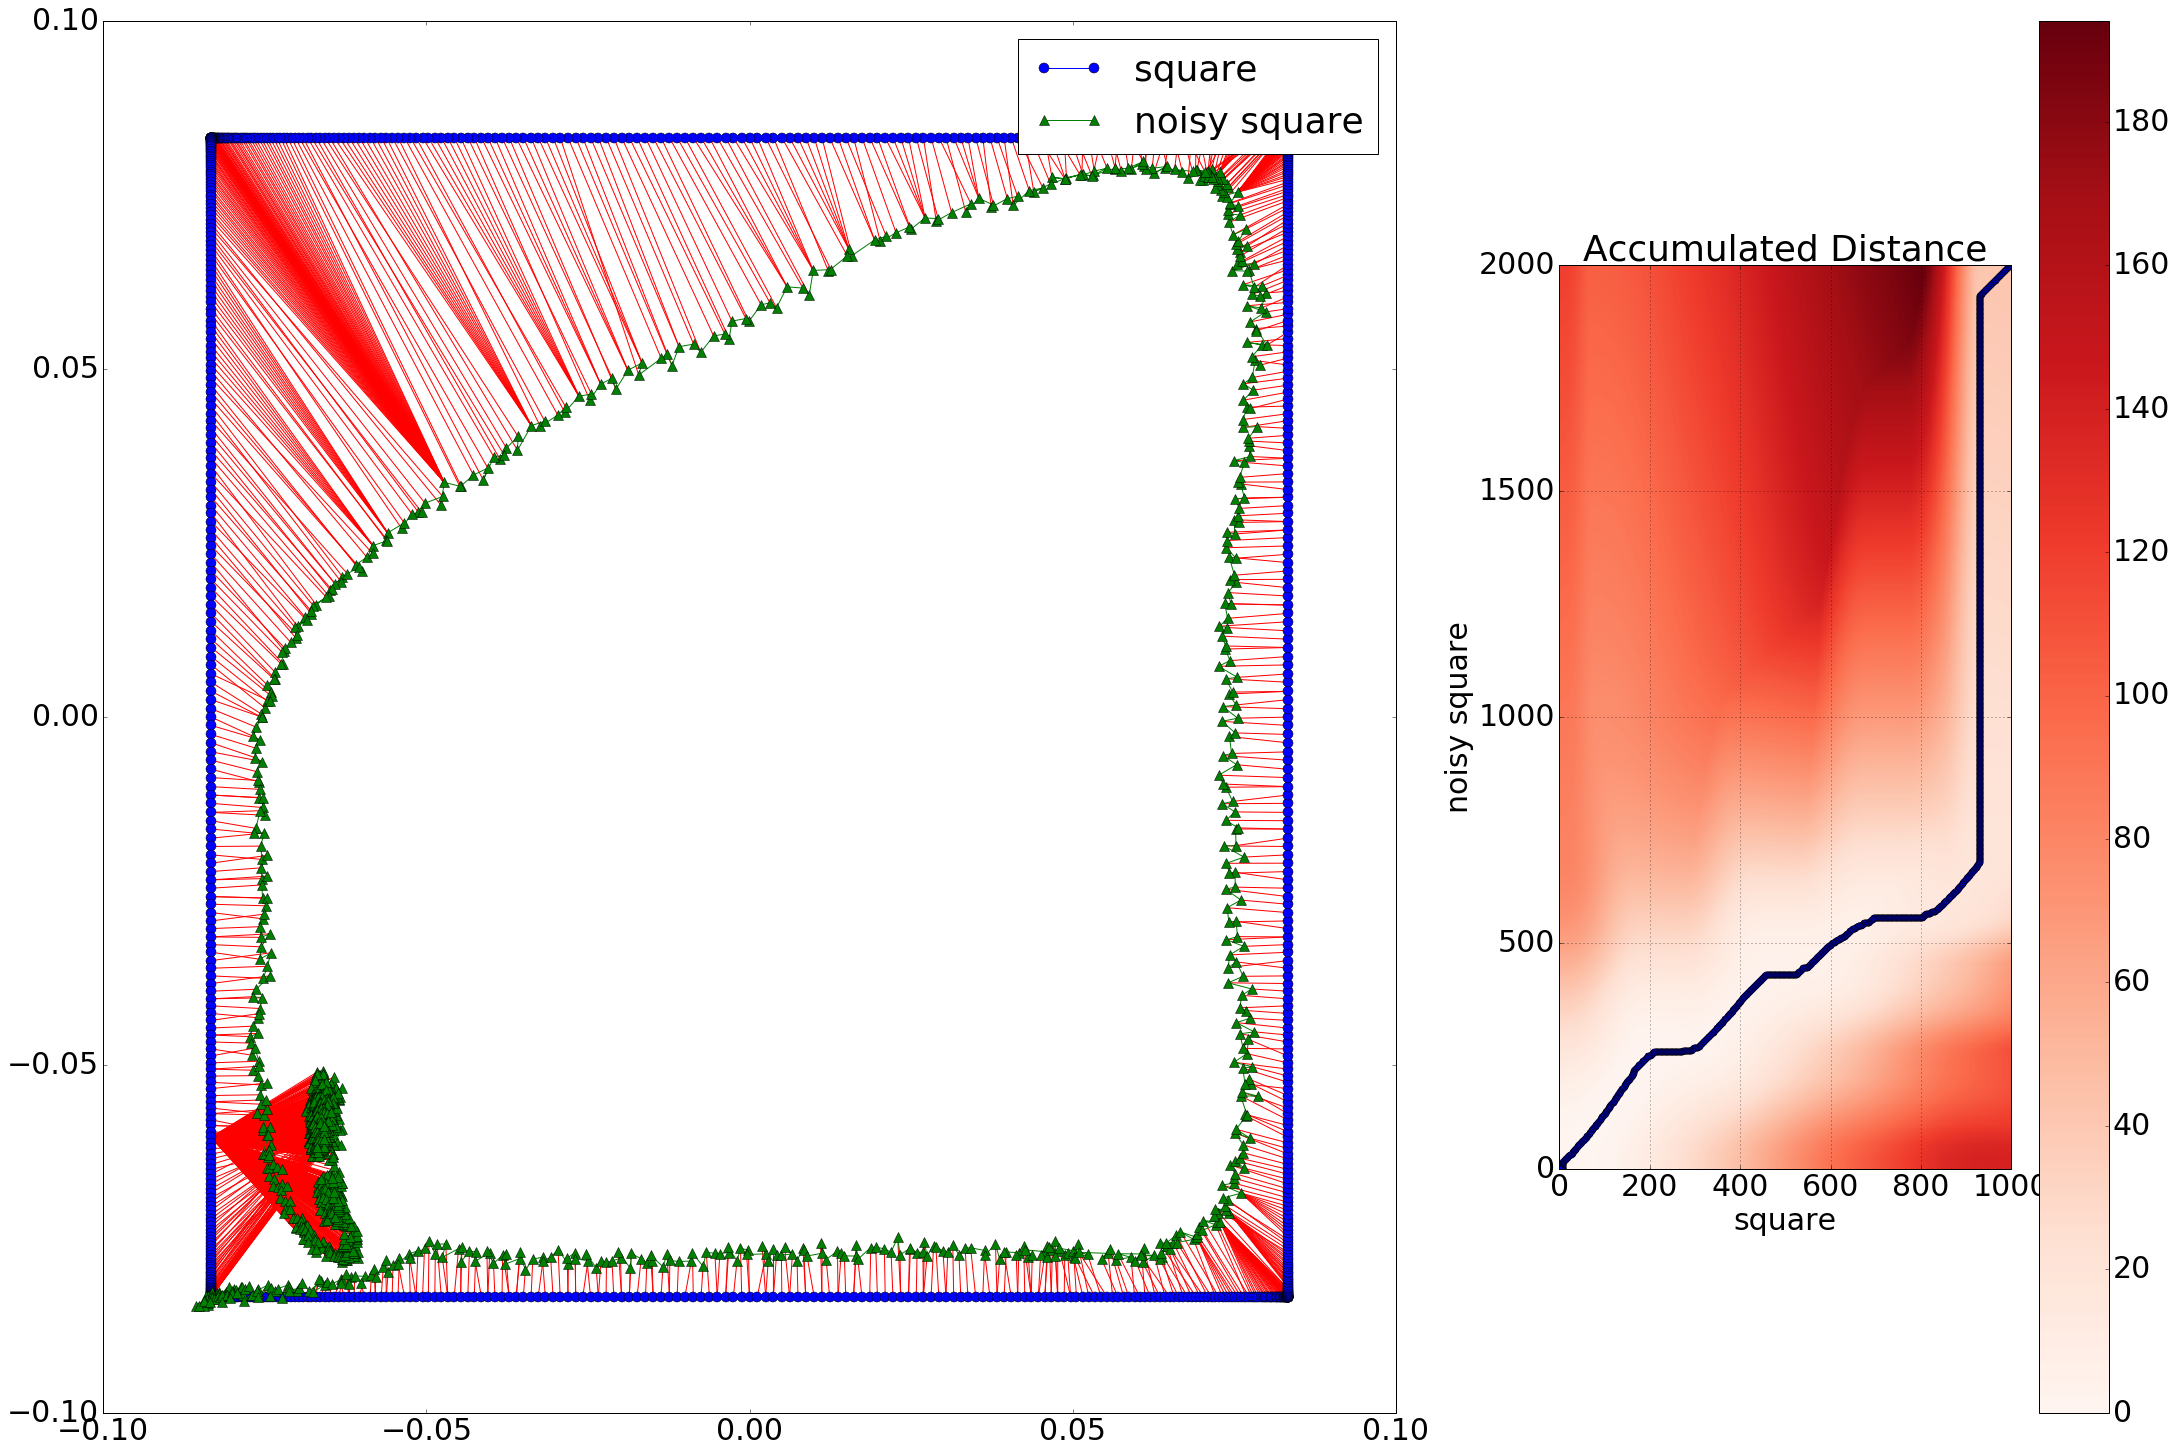

In [13]:
font = {'weight' : 'normal',
        'size'   : 30}

matplotlib.rc('font', **font)

plt.figure(figsize =(30,20))
plt.subplot2grid((1,3),(0,0),colspan=2)
for [map_c, map_e] in path:
    plt.plot([square[map_c,0],noisy_sq[map_e,0]],[square[map_c,1],noisy_sq[map_e,1]] , 'r')

plt.plot(square[:,0],square[:,1], 'bo-' ,label='square', markersize=10)
plt.plot(noisy_sq[:,0],noisy_sq[:,1], 'g^-', label = description, markersize=10)
plt.legend()
# plt.xlim(-1.1,1.1)
# plt.ylim(-1.1,1.1)

plt.subplot2grid((1,3),(0,2))
ax=distance_cost_plot(accumulated_cost,xlabel="square",ylabel=description, figure=False)
plt.title("Accumulated Distance")
plt.plot(path[:,0],path[:,1],'o-')
plt.xlim(0,path[0,0])
plt.ylim(0,path[0,1])

plt.tight_layout(pad=0, h_pad=0, w_pad=0.5, rect=None)
plt.savefig("./ICONIP2016_example_dtw.pdf", bbox_inches='tight',pad_inches=.1)
plt.show()

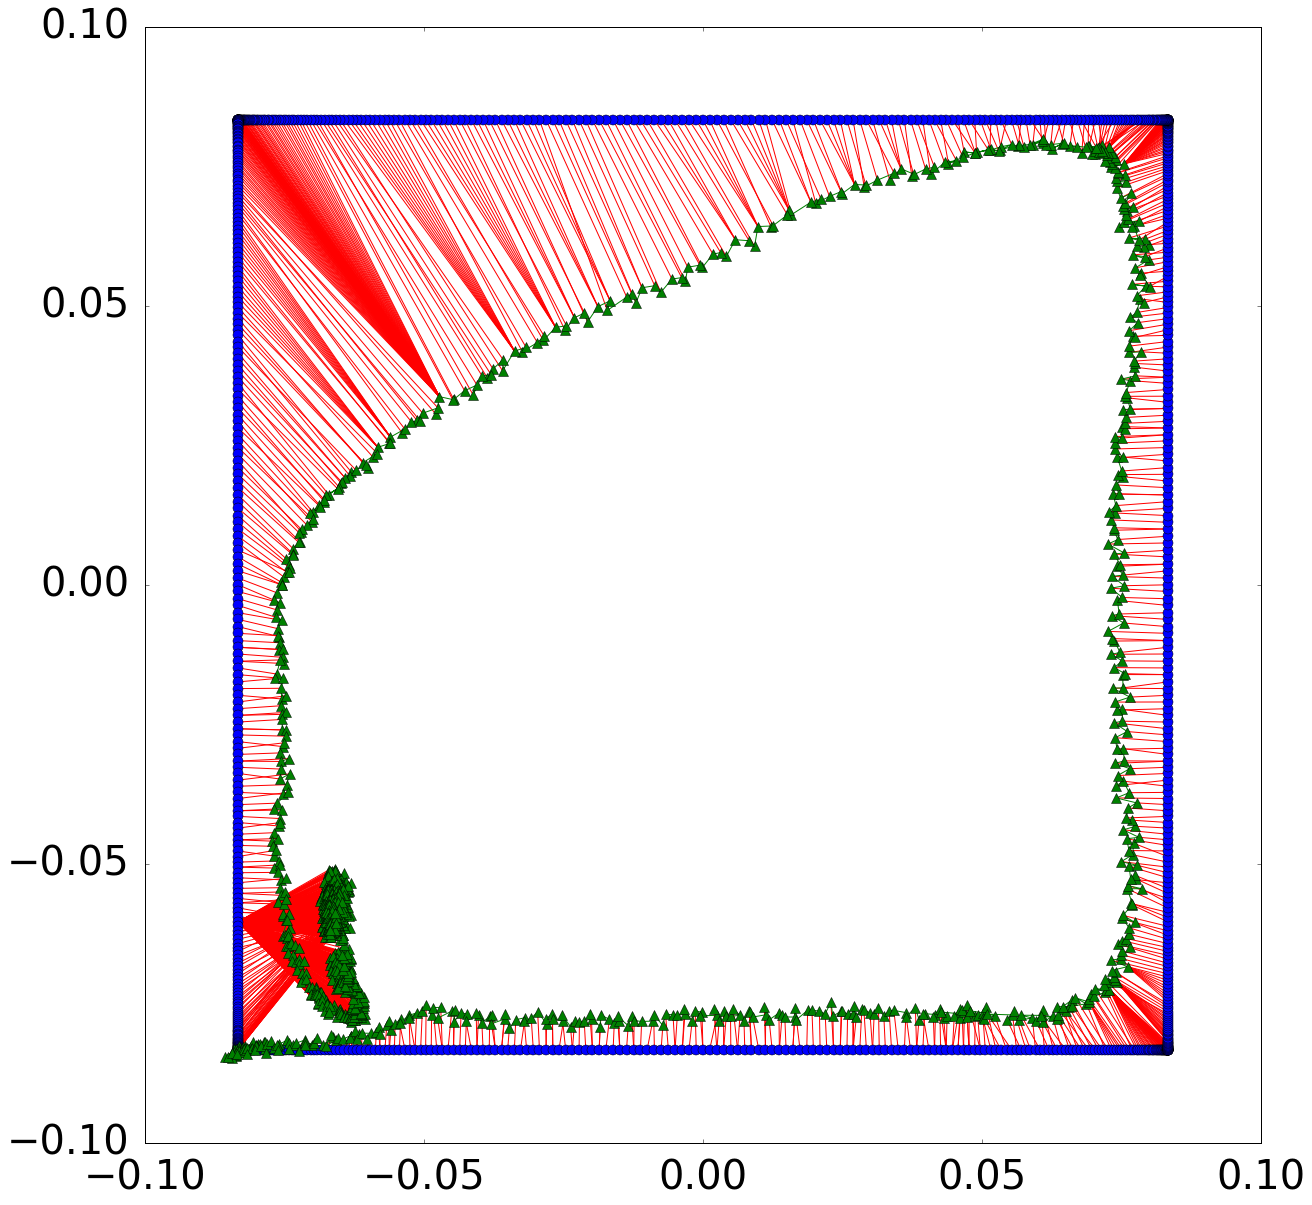

In [22]:
plt.figure(figsize =(20,20))
ax = plt.gca()
for [map_c, map_e] in path:
    ax.plot([square[map_c,0],noisy_sq[map_e,0]],[square[map_c,1],noisy_sq[map_e,1]] , 'r')

ax.plot(square[:,0],square[:,1], 'bo-' ,label='square', markersize=10)
ax.plot(noisy_sq[:,0],noisy_sq[:,1], 'g^-', label = description, markersize=10)

ax.tick_params(axis='both', pad=15, labelsize=40)

# plt.savefig("./ICONIP2016_example_dtw_squares.pdf", bbox_inches='tight',pad_inches=.1)
plt.savefig("./ICONIP2016_example_dtw_squares.png", bbox_inches='tight',pad_inches=.1, dpi=150)
plt.show()

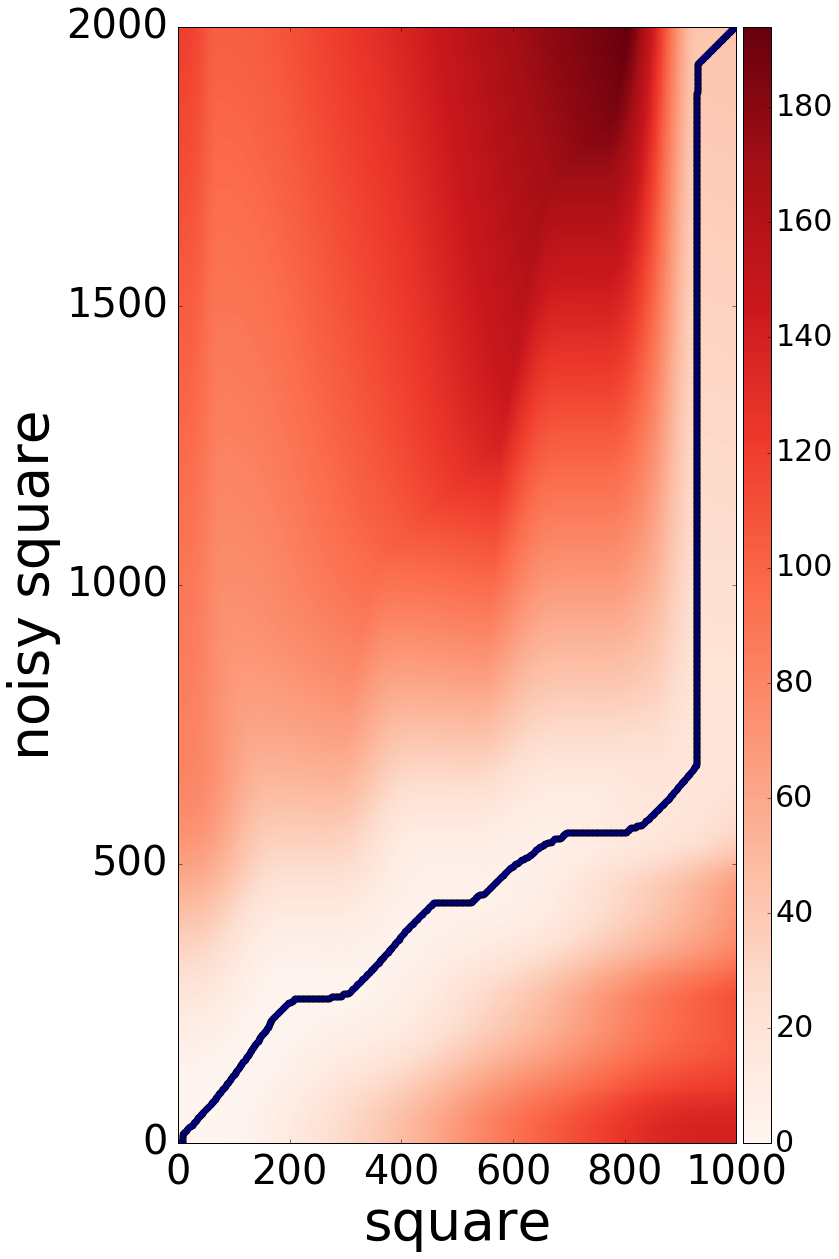

In [21]:
# http://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#axesdivider
from mpl_toolkits.axes_grid1 import make_axes_locatable

distances=accumulated_cost.T
xlabel="square"
ylabel=description

plt.figure(figsize =(20,20))

ax = plt.gca()

im = ax.imshow(distances, interpolation='nearest', cmap='Reds') 
ax.invert_yaxis()

ax.tick_params(axis='both', pad=10, labelsize=40)
# ax.tick_params(axis='y', pad=10, labelsize=50)

ax.set_xlabel(xlabel, labelpad=5, fontdict={'fontsize':55})
ax.set_ylabel(ylabel, labelpad=5, fontdict={'fontsize':55})

plt.plot(path[:,0],path[:,1],'o-')
plt.xlim(0,1000)
plt.ylim(0,path[0,1])

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.grid()
plt.colorbar(im, cax=cax)

# plt.savefig("./ICONIP2016_example_dtw_acc_dist.pdf", bbox_inches='tight',pad_inches=.1)
plt.savefig("./ICONIP2016_example_dtw_acc_dist.png", bbox_inches='tight',pad_inches=.1, dpi=150)
plt.show()